# Lane Whitmore

# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
import itertools


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = len(set(tokens)) / len(tokens)
    num_characters = 0

    # character count
    for i in tokens:
        for c in i:
            num_characters += 1

    common = Counter(tokens).most_common(5)

    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The five most common words {common} in the data.")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters, common])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [w for w in tokens if w not in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    text = [item.lower() for item in whitespace_pattern.split(text)]
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

#### Twitter Data

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/whitm/OneDrive/Desktop/ADS509/M1_Assignment_Data/M1_Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robyn_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


#### Lyrics Data

In [8]:
# read in the lyrics here
# Read in the lyrics data
artists = ['robyn','cher']

# List for lyrics and titles
r_lyrics = []
c_lyrics = []

# lists for artists names
r = []
c = []
for a in artists:
    for file in os.listdir(f'{data_location}{lyrics_folder}'+a+'/'):
        if file.endswith('.txt'):
            with open(f'{data_location}{lyrics_folder}'+a+'/'+file,'r') as data:
                if a == 'robyn':
                    r_lyrics.append(data.read())
                    r.append('Robyn')
                else:
                    c_lyrics.append(data.read())
                    c.append('Cher')
        else:
            print("Error File Not Text")

lyrics = pd.DataFrame({"artist": r+c, "lyrics": r_lyrics+c_lyrics})

In [9]:
titles = []
li_lyrics = []
for i in lyrics['lyrics']:
    # splitting lyrics from titles
    x, y = i.split('\n\n\n\n')
    # appending titles and lyrics for placement in a dataframe
    titles.append(x.replace('"', ''))
    li_lyrics.append(y.replace('\n',' ').replace('[Verse 1:]', '').replace('[Verse 2:]', '').replace('[Verse 3:]', '').replace('[Verse 4:]', '').replace('[Verse 5:]', ''))

# putting new lyrics and titles columns into dataframe
lyrics['lyrics'] = li_lyrics
lyrics['titles'] = titles

lyrics.head()

,artist,lyrics,titles
0,Robyn,I light a candle in the morning To signify th...,88 Days
1,Robyn,"Boy you gotta want me, really really want me ...",Ain't No Thing
2,Robyn,It's like you're waiting for me to start There...,Anytime You Like
3,Robyn,"Here come the night In your eyes Baby, be brav...",Baby Forgive Me
4,Robyn,(So you wanna go out? How you gonna get there?...,Beach 2K20


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [10]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics["tokens"] = lyrics["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics["num_tokens"] = lyrics["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [11]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
814241,cher,Brasileira Beyoncé 👸😍❤️,"[brasileira, beyoncé, 👸😍❤️]"
264935,robyn,#GWAPCITY TILL THIS WORLD BLOW ` #OVOXO - » $i...,"[#gwapcity, till, world, blow, #ovoxo, », ingl..."
346346,cher,Robin Williams is God🖖🏼 ✌🏼❤️🇨🇦.ca #LoveMoreJud...,"[robin, williams, god🖖🏼, ✌🏼❤️🇨🇦ca, #lovemoreju..."
62446,robyn,Proverbs 3:5 Trust in the LORD with all thine ...,"[proverbs, 35, trust, lord, thine, heart, lean..."
945495,cher,She/Her/Hers. Mrs.Tedstone-Woods. Twin Mama to...,"[sheherhers, mrstedstonewoods, twin, mama, max..."
929294,cher,🌈 she/her/they ✨,"[🌈, sheherthey, ✨]"
1052159,cher,M O R G A N💋💍 AMOSC- Morgann1129💥,"[r, g, n💋💍, amosc, morgann1129💥]"
159368,cher,"💗 solo's, manti's, weird shippers and kboos dn...","[💗, solos, mantis, weird, shippers, kboos, dni..."
375355,cher,✨🧞‍♀️🔮🦋🌼🧚🏼🌸🌾🕺🏻,[✨🧞‍♀️🔮🦋🌼🧚🏼🌸🌾🕺🏻]
1497405,cher,love life. I love rock @ metal. I only speak a...,"[love, life, love, rock, metal, speak, read, e..."


In [13]:
lyrics.head()

,artist,lyrics,titles,tokens,num_tokens
0,Robyn,I light a candle in the morning To signify th...,88 Days,"[light, candle, morning, signify, still, mind,...",204
1,Robyn,"Boy you gotta want me, really really want me ...",Ain't No Thing,"[, boy, gotta, want, really, really, want, boy...",62
2,Robyn,It's like you're waiting for me to start There...,Anytime You Like,"[like, youre, waiting, start, theres, right, m...",118
3,Robyn,"Here come the night In your eyes Baby, be brav...",Baby Forgive Me,"[come, night, eyes, baby, brave, wise, like, m...",76
4,Robyn,(So you wanna go out? How you gonna get there?...,Beach 2K20,"[wanna, go, gonna, get, ok, call, someone, alr...",173


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: 
1. Right now, there are some empty strings within the token lists '' that need to be removed. 

2. Additionally, potentially stopwords could be customized further to the our liking / use.  Some examples would include all of the different iterations of hi in twitter descriptions like "hiiiii". 

3. There are also more opportunities for further cleaning in the 9For instance, in the print above for twitter descriptions have words that are comma separated but are not separated by whitespace. This led to combination tokens like "retireebelieve" using the whitespace split method. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


#### Robyn Descriptive Statistics

In [14]:
# listing itertools makes the short lists into one long list for the function that was created in assignment 2
d = descriptive_stats(list(itertools.chain.from_iterable(lyrics[lyrics['artist']=='Robyn']['tokens'])), verbose=True)


There are 15138 tokens in the data.
There are 2140 unique tokens in the data.
There are 72780 characters in the data.
The lexical diversity is 0.141 in the data.
The five most common words [('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)] in the data.


#### Cher Descriptive Statistics

In [15]:
d = descriptive_stats(list(itertools.chain.from_iterable(lyrics[lyrics['artist']=='Cher']['tokens'])), verbose=True)

There are 35549 tokens in the data.
There are 3685 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.104 in the data.
The five most common words [('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)] in the data.


Q: what observations do you make about these data? 

A: 
1. Very similar top words. It is easy to tell their music revolves around love and relations as well as taking on an "I" narration quite often in their music. 

2. Robyn does have slightly more lexical diversity in her lyrics. 

3. Overall, Cher has a much larger discography. In my opinion, a larger discography would like mean a lower lexical diversity. If Robyn had nearly 2x the amount of lyrics like Cher does, she would be more likely to recycle some of her words and lower her lexical diversity. 

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

#### Comments on Vectorizing

I ended up choosing min_df = 0.002 for the descriptions as it left a large dataset to work with without causing too much stress to my machine. A couple more zeroes (0.00002) causes VSC to have memory errors with the Cher data particularly as it is so long. 0.002 ended up feeling like a good number to quickly recieve results. This also ensures that all words appear more than 5 times in all four count vectors.

In [16]:
# your code here
rl_cv = CountVectorizer(stop_words = sw, min_df=5)
rl_cv.fit(lyrics[lyrics['artist']=='Robyn']['lyrics'])
rl_dt = rl_cv.transform(lyrics[lyrics['artist']=='Robyn']['lyrics'])

cl_cv = CountVectorizer(stop_words = sw, min_df=5)
cl_cv.fit(lyrics[lyrics['artist']=='Cher']['lyrics'])
cl_dt = cl_cv.transform(lyrics[lyrics['artist']=='Cher']['lyrics'])


rd_cv = CountVectorizer(stop_words = sw, min_df=0.002)
rd_cv.fit(twitter_data[twitter_data['artist']=='robyn']['description'].dropna())
rd_dt = rd_cv.transform(twitter_data[twitter_data['artist']=='robyn']['description'].dropna())

cd_cv = CountVectorizer(stop_words = sw, min_df=0.002)
cd_cv.fit(twitter_data[twitter_data['artist']=='cher']['description'].dropna().reset_index(drop=True))
cd_dt = cd_cv.transform(twitter_data[twitter_data['artist']=='cher']['description'].dropna().reset_index(drop=True))


In [17]:
rl_df = pd.DataFrame(rl_dt.toarray(), columns = rl_cv.get_feature_names_out())
cl_df = pd.DataFrame(cl_dt.toarray(), columns = cl_cv.get_feature_names_out())

rd_df = pd.DataFrame(rd_dt.toarray(), columns = rd_cv.get_feature_names_out())
cd_df = pd.DataFrame(cd_dt.toarray(), columns = cd_cv.get_feature_names_out())

#### Robyn Lyrics Corpus

In [18]:
# concentration function
def concentration(df):
    # lists for df
    column_sums = []
    col_names = []

    # appending sum of columns
    for column in df:
        column_sums.append(sum(df[column]))

# appending words
    for i in df.columns:
        col_names.append(i)
    
    # creating df
    new_df = pd.DataFrame({'col_sums': column_sums, 'col_names': col_names}) 

    # sum of sums for the total frequency
    total_sum = (sum(column_sums))

    # creating concentration freq / total freq
    new_df['concentration'] = new_df['col_sums'] / total_sum

    return new_df
    

# Function to compare concentrations
def comp_concentration(df1, df2):
    # store lists for df 
    words = []
    ratio = []
    df2r = []
    df1r =[]
    # Extract df name to show that it is missing key words
    name = [x for x in globals() if globals()[x] is df2][0]
    # looping through the 10 highest concentration words for df1
    for i in df1.sort_values('concentration', ascending = False).head(10)['col_names']:
        # creating if | else in case that word is not present in df2
        if df2[df2['col_names']==i]['concentration'].empty == True:
            # print word that isn't present
            print(f"Word {i} is not in the dataframe {name} ")
        else:
            # append the words
            words.append(i)

            # append concentration ratio
            ratio.append(float(df1[df1['col_names']==i]['concentration']) / float(df2[df2['col_names']==i]['concentration']))
            
            # append original concentrations
            df2r.append(float(df2[df2['col_names']==i]['concentration']))
            df1r.append(float(df1[df1['col_names']==i]['concentration']))

    # create df to return
    data = pd.DataFrame({'words': words, 'concentration1': df1r, 'concentration2': df2r, 'concentration_ratio': ratio})
    return data


In [19]:
rl_con = concentration(rl_df)
rl_con.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
116,305,know,0.036483
133,270,love,0.032297
95,250,got,0.029904
124,230,like,0.027512
9,220,baby,0.026316
157,155,never,0.018541
46,148,dance,0.017703
12,144,beat,0.017225
83,141,get,0.016866
120,132,let,0.015789


#### Cher Lyrics Corpus

In [20]:
cl_con = concentration(cl_df)
cl_con.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
352,985,love,0.039312
304,482,know,0.019237
419,325,oh,0.012971
28,315,baby,0.012572
597,315,time,0.012572
497,308,see,0.012292
421,281,one,0.011215
227,274,go,0.010936
330,267,like,0.010656
105,264,come,0.010536


#### Concentration ratio comparison

In [21]:
rlclcomp = comp_concentration(rl_con, cl_con)
rlclcomp

,words,concentration1,concentration2,concentration_ratio
0,know,0.036483,0.019237,1.896524
1,love,0.032297,0.039312,0.821548
2,got,0.029904,0.009579,3.122010
3,like,0.027512,0.010656,2.581797
4,baby,0.026316,0.012572,2.093233
5,never,0.018541,0.009938,1.865683
6,dance,0.017703,0.000998,17.743005
7,beat,0.017225,0.000718,23.977033
8,get,0.016866,0.006266,2.691689
9,let,0.015789,0.006066,2.602770


In [22]:
clrlcomp = comp_concentration(cl_con, rl_con)
clrlcomp

,words,concentration1,concentration2,concentration_ratio
0,love,0.039312,0.032297,1.217214
1,know,0.019237,0.036483,0.527281
2,oh,0.012971,0.007895,1.642986
3,baby,0.012572,0.026316,0.477730
4,time,0.012572,0.012440,1.010582
5,see,0.012292,0.006818,1.802895
6,one,0.011215,0.007656,1.464944
7,go,0.010936,0.011124,0.983020
8,like,0.010656,0.027512,0.387327
9,come,0.010536,0.008612,1.223393


#### Cher Descriptions Corpus

In [23]:
cd_con = concentration(cd_df)
cd_con.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
313,225269,love,0.034250
293,133473,life,0.020293
350,97188,music,0.014776
97,75507,co,0.011480
126,73521,de,0.011178
314,66226,lover,0.010069
193,65040,follow,0.009889
296,59659,like,0.009070
341,59280,mom,0.009013
259,52763,https,0.008022


#### Robyn Description Corpus

In [24]:
rd_con = concentration(rd_df)
rd_con.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
340,16247,music,0.027575
90,13581,co,0.023050
301,12224,love,0.020747
246,8090,https,0.013731
283,7977,life,0.013539
362,7943,och,0.013481
116,6469,de,0.010980
182,5791,follow,0.009829
302,5168,lover,0.008771
286,5038,like,0.008551


#### Twitter Description ration comparison

In [25]:
rdcdcomp = comp_concentration(rd_con, cd_con)
rdcdcomp

Word och is not in the dataframe cd_con 


,words,concentration1,concentration2,concentration_ratio
0,music,0.027575,0.014776,1.866173
1,co,0.023050,0.011480,2.007871
2,love,0.020747,0.034250,0.605764
3,https,0.013731,0.008022,1.711632
4,life,0.013539,0.020293,0.667171
5,de,0.010980,0.011178,0.982239
6,follow,0.009829,0.009889,0.993950
7,lover,0.008771,0.010069,0.871135
8,like,0.008551,0.009070,0.942700


In [26]:
cdrdcomp = comp_concentration(cd_con, rd_con)
cdrdcomp

,words,concentration1,concentration2,concentration_ratio
0,love,0.034250,0.020747,1.650809
1,life,0.020293,0.013539,1.498865
2,music,0.014776,0.027575,0.535856
3,co,0.011480,0.023050,0.498040
4,de,0.011178,0.010980,1.018082
5,lover,0.010069,0.008771,1.147928
6,follow,0.009889,0.009829,1.006087
7,like,0.009070,0.008551,1.060783
8,mom,0.009013,0.002110,4.272143
9,https,0.008022,0.013731,0.584238


### Looking at words only used in each corpera

Disclaimer is these lists are limited. for lyrics, only tokens with more than 5 appearances will be listed. for descriptions only those with concentrations higher than 0.002 will be listed

In [87]:
def unique_tokens(df1, df2):

    df1col = []
    df2col = []

    for i in df1.columns:
        df1col.append(i)
    for i in df2.columns:
        df2col.append(i)
    return [x for x in df1col if x not in df2col]

def extract_df(df, unique):
    words = []
    sums = []
    concentration = []
    for i in unique:
        words.append(df[df['col_names'] == i]['col_names'].item())
        sums.append(df[df['col_names'] == i]['col_sums'].item())
        concentration.append(df[df['col_names'] == i]['concentration'].item())

    data = pd.DataFrame({'col_sums': words,'col_names':sums, 'concentration':concentration})
    return data
        


#### Unique Lyrics Words

In [92]:
rlunique = unique_tokens(rl_df, cl_df)
print("Number of Unique Robyn Lyrics", len(rlunique))

clunique = unique_tokens(cl_df, rl_df)
print("Number of Unique Cher Lyrics", len(clunique))

Number of Unique Robyn Lyrics 28
Number of Unique Cher Lyrics 440


In [99]:
rluniquedf = extract_df(rl_con, rlunique)
rluniquedf.sort_values('concentration', ascending = False)

,col_sums,col_names,concentration
2,boom,56,0.006699
8,fuck,35,0.004187
14,ok,30,0.003589
1,bomb,21,0.002512
3,check,17,0.002033
7,fit,16,0.001914
23,style,16,0.001914
25,x1,15,0.001794
9,girls,15,0.001794
19,shit,15,0.001794


In [100]:
cluniquedf = extract_df(cl_con, clunique)
cluniquedf.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
406,walk,114,0.004550
430,without,84,0.003352
4,ah,63,0.002514
389,tonight,59,0.002355
222,lonely,58,0.002315
300,rain,55,0.002195
386,till,55,0.002195
343,sleep,54,0.002155
439,young,50,0.001996
47,broken,49,0.001956


#### Unique Description Words

In [96]:
rdunique = unique_tokens(rd_df, cd_df)
print("Number of Unique Robyn Lyrics", len(rdunique))

cdunique = unique_tokens(cd_df, rd_df)
print("Number of Unique Cher Lyrics", len(cdunique))

Number of Unique Robyn Lyrics 107
Number of Unique Cher Lyrics 122


In [101]:
rduniquedf = extract_df(rd_con, rdunique)
rduniquedf.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
65,och,7943,0.013481
75,på,4778,0.008109
105,är,3359,0.005701
84,som,3309,0.005616
58,med,2837,0.004815
49,jag,2563,0.004350
37,för,2065,0.003505
66,og,2032,0.003449
5,att,1706,0.002896
92,sweden,1645,0.002792


In [102]:
cduniquedf = extract_df(cd_con, cdunique)
cduniquedf.sort_values('concentration', ascending = False).head(10)

,col_sums,col_names,concentration
85,retired,18978,0.002885
28,daughter,14633,0.002225
26,country,14310,0.002176
83,resist,13431,0.002042
20,children,12542,0.001907
64,liberal,11202,0.001703
29,democrat,10052,0.001528
90,sister,10049,0.001528
15,blue,9514,0.001446
108,trump,9310,0.001415


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 

1. Lyrics:
Both artists have extremely similar lists. The most similar being; "love", "baby", & "know". Some interesting differences is "dance" and "beat" for Robyn and "time" for Cher. For Robyn, her music really focused on transitioning rock music to more dance-driven and experimental, which would explain dance and beat usage. Cher sings a lot about relationships and the passing of time so this could explain her use of time. Both focus on singing about love primarily, so it is no surprise that they  reference love, baby, and life quite often. Robyn has the largest differences of the bunch in her lyrics with dance and beat both being around a 20 ratio. This really points out the difference in their overall themes and motives as Robyn, again, is very focused on pushing the genre towards dance music. Rather surpisingly, as well, the words that appear more than 5 times reveal that Cher has quite a bit more words unique to her corpus than Robyn does. Robyn's did include curse words as she used more explicit language. 


2. Descriptions:
Both Cher's twitter user fans and Robyn's twitter user fans have love, life, and music featured in their descriptions. Many of them also have links within their as shown by https and co token. Additionally both have "de" within their highest concentration which points out that many latin language speakers are listening to both artists. One difference is "mom" appears within Cher's top 10 which points out that she likely has more mothers listening to her music than Robyn, at least among Twitter users. Cher users have used the words love and life much more often although they appear in both's top 10 words. "mom" is referenced much more often in Cher's users descriptions with a 4.2 ratio. Robyn's listeners descriptions were much more often to have web links within their descriptions. Both had a similar amount of unique words. Cher had many more self-described actresses (which could be due to Cher's acting career) and more self described artists listen to Robyn. 


## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [27]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {tokens:freq for (tokens, freq) in counter.items() 
                              if tokens not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'tokens'
    
    return freq_df.sort_values('freq', ascending=False)

In [28]:
r_lyr = count_words(lyrics[lyrics['artist']=='Robyn'])
c_lyr = count_words(lyrics[lyrics['artist']=='Cher'])
c_twit = count_words(twitter_data[twitter_data['artist']=='cher'].dropna())
r_twit = count_words(twitter_data[twitter_data['artist']=='robyn'].dropna())
r_lyr.head()

,freq
tokens,
know,305
im,299
dont,297
love,269
got,249


#### Robyn Lyrics

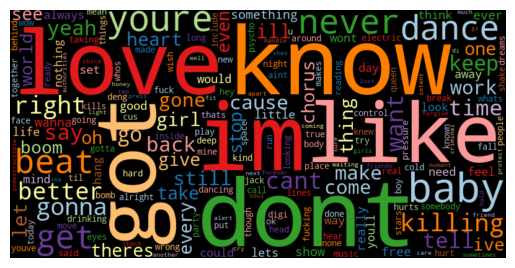

In [29]:
wordcloud(r_lyr['freq'], max_words = 200, stopwords=sw)

#### Cher Lyrics

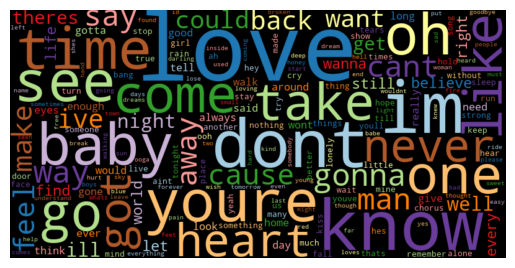

In [30]:
wordcloud(c_lyr['freq'], max_words = 200, stopwords=sw)

#### Robyn Twitter 

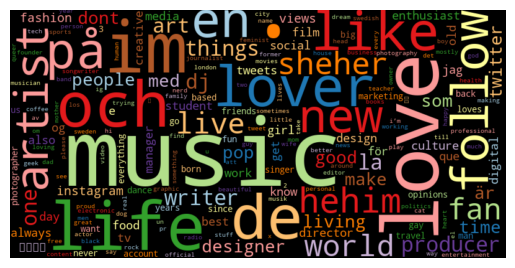

In [31]:
wordcloud(r_twit['freq'], max_words = 200, stopwords=sw)

#### Cher Twitter

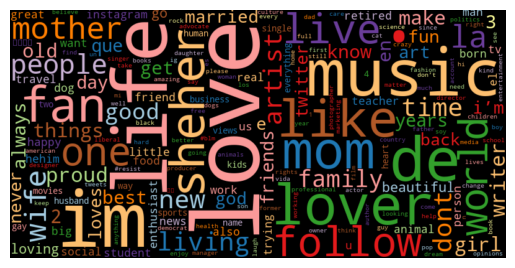

In [43]:
wordcloud(c_twit['freq'], max_words = 200, stopwords=sw)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: 

1. Lyrics:
Again, both have love songs that are at the forefront of their lexicons. Robyn has more words like party, free, and electric that hint at her more dance focused tunes. Cher's smaller words are still love related mostly such as babe, heart, and man. 

2. Descriptions:
One thing I notice is that both grouping identify their pronouns. Again, Cher has mother and mom in her listeners descriptions, meaning much of her audience are mothers. Robyn does have a tiny dad and a large he/him that Cher does not have. This perhaps points out that Robyn has a larger male audience while Cher has a larger female audience. Perhaps Robyn has more of masculine audience than Cher because Cher's lexicon seems to focus more on love from the perspective of women rather than more dance tunes like Robyn makes. 
